# Домашнее задание #2. Фильтр частиц

В этом домашнем задании мы реализуем алгоритмо оценки собственного положения робота известный как фильтр частиц.
Фильтр частиц состоит из следующих шагов:
1. Движение частиц в соответсвии с кинематической моделью движения. Движение осуществляется с помощью вероятностной функции движения, учитывающей случайность процесса (шумы параметров движения).
2. Сопоставление полученного измерения с ожидаемым, путем применения вероятностной функции измерения, оценивающей вероятность полученного измерения при условии фиксированного положения частицы. В результате этого шага какждой частице присваивается вес пропорциональный правдоподобию измерения при условии заданного положения частицы.
3. Ремемплинг - процесс при котором вероятность частицы войти в новую выборку пропорциональна весу (правдоподобию) частиц. 


## Задание 1
 
Реализуйте модель движения мобильного робота $p(x_{t+1}|x_t, u_t)$ в составе класса *Robot*. Метод должен иметь название *move()*. Метод *move()* принимает на вход текущее положение робота и вектор управляющих сигналов (угол поворота рулей ($\alpha$) и расстояние, на которое должен переместиться робот ($d$)). Метод *move()* должен возвращать экземпляр класса *Robot* с новым вектором состояния $(x, y, \theta)$.

Для этого домашнего задания мы будем предполагать, что наш робот имеет автомобильную кинематику. Такая кинематика описывается [велосипедной моделью](https://nabinsharma.wordpress.com/2014/01/02/kinematics-of-a-robot-bicycle-model/) (также можно обратиться к Лекции 3.Трицикл, однако внимательно т.к. есть расхождения в обозначениях). Именно велосипедную модель необходимо реализовать в методе *move()* в качестве аппроксимации автомобильной кинематики. 

**Важно:** координаты $(x, y)$ вектора состояния робота задают положение центра задней колесной оси робота. 

**Важно:** Метод *move()* также должен моделировать шум управляющих сигналов. Для этого к каждой компоненте вектора управляющих сигналов применяется аддитивный нормальный шум. Шум угла поворота рулей задается атрибутом класса Robot.steering_noise. Шум перемещения задаются атрибутом класса Robot.distance_noise. Параметры *Robot.steering_noise* и *Robot.distance_noise* задают СКО ($\sigma$) нормального распределения.

In [1]:
from math import *
import random

In [2]:
# --------
# 
# the "world" has 4 landmarks.
# the robot's initial coordinates are somewhere in the square
# represented by the landmarks.

landmarks  = [[0.0, 100.0], [0.0, 0.0], [100.0, 0.0], [100.0, 100.0]] # position of 4 landmarks
world_size = 100.0 # world is NOT cyclic. Robot is allowed to travel "out of bounds"

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt


class Robot:

    # --------

    # init: 
    #   creates robot and initializes location/orientation 
    #

    def __init__(self, length = 10.0):
        self.x = np.random.random() * world_size # initial x position
        self.y = np.random.random() * world_size # initial y position
        self.orientation = np.random.random() * 2.0 * math.pi # initial orientation
        self.length = length # length of robot
        self.bearing_noise  = 0.0 # initialize bearing noise to zero
        self.distance_noise = 0.0 # initialize distance noise to zero
        self.steering_noise = 0.0 # initialize steering noise to zero

    
    def __repr__(self):
        return '[x=%.6s y=%.6s theta=%.6s]' % (str(self.x), str(self.y), str(self.orientation))
    # --------
    # set: 
    #   sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        if new_orientation < 0 or new_orientation >= 2 * math.pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_b_noise, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.bearing_noise  = float(new_b_noise)
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)
    
    ############# ONLY ADD/MODIFY CODE BELOW ###################

    # --------
    # move:
    #   move along a section of a circular path according to motion parameters
    #
    
    def move(self, motion, no_noise = True):
         # make sure your move function returns an instance of Robot class
         # with the correct coordinates.
        if (not no_noise):
            motion[0] += np.random.normal(0,self.steering_noise)
            motion[1] += np.random.normal(0,self.distance_noise)
            
        if (motion[0] == 0):
            self.x = self.x + motion[1] * math.cos(self.orientation)
            self.y = self.y + motion[1] * math.sin(self.orientation)
        else:
            R = self.length / math.tan(motion[0])
            b = motion[1] / R 
            
            x_c = self.x - R * math.sin(self.orientation)
            y_c = self.y + R * math.cos(self.orientation)
            self.orientation = (self.orientation + b + 2.0*math.pi) % (2.0*math.pi)
            self.x = x_c + R * math.sin(self.orientation)
            self.y = y_c - R * math.cos(self.orientation)
            
        return self
    
    def sense(self, no_noise = True):
        ans = []
        for mark in landmarks:
            x = mark[1] - self.x
            y = mark[0] - self.y
            angl = (math.atan2(y, x) - self.orientation)
            if (not no_noise):
                angl += np.random.normal(0,self.bearing_noise)
                
            angl = (angl + 2.0*math.pi)  % (2.0*math.pi)
            ans.append(angl)
            
        return ans
    
    def measurement_prob(self, measurement):
        prob = 1.0
        meas = self.sense()
        for i in range(len(measurement)):
            measurement[i] = (measurement[i] + 2.0*math.pi) %  (2.0*math.pi)
            meas[i] = (meas[i] + 2.0*math.pi) % (2.0*math.pi)
            
            dif = abs(measurement[i] - meas[i])
            dif = min(dif, 2.0*math.pi - dif)
            
            prob *= math.exp(-dif ** 2 / 2.0 / self.bearing_noise ** 2) / self.bearing_noise / math.sqrt(2.0*math.pi)
        
        return np.nan_to_num(prob);
    ############## ONLY ADD/MODIFY CODE ABOVE ####################

In [4]:
## --------
## TEST CASE #1:
## 
## The following code should print:
##       Robot:     [x=0.0 y=0.0 theta=0.0]
##       Robot:     [x=10.0 y=0.0 theta=0.0]
##       Robot:     [x=19.861 y=1.4333 theta=0.2886]
##       Robot:     [x=39.034 y=7.1270 theta=0.2886]
##

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = Robot(length)
myrobot.set(0.0, 0.0, 0.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

motions = [[0.0, 10.0], [pi / 6.0, 10], [0.0, 20.0]]

T = len(motions)

print('Robot:    ', myrobot)
for t in range(T):
    myrobot = myrobot.move(motions[t])
    print('Robot:    ', myrobot)

Robot:     [x=0.0 y=0.0 theta=0.0]
Robot:     [x=10.0 y=0.0 theta=0.0]
Robot:     [x=19.861 y=1.4333 theta=0.2886]
Robot:     [x=39.034 y=7.1270 theta=0.2886]


In [5]:
## --------
## TEST CASE #2:
## 
## The following code should print:
##      Robot:     [x=0.0 y=0.0 theta=0.0]
##      Robot:     [x=9.9828 y=0.5063 theta=0.1013]
##      Robot:     [x=19.863 y=2.0201 theta=0.2027]
##      Robot:     [x=29.539 y=4.5259 theta=0.3040]
##      Robot:     [x=38.913 y=7.9979 theta=0.4054]
##      Robot:     [x=47.887 y=12.400 theta=0.5067]
##      Robot:     [x=56.369 y=17.688 theta=0.6081]
##      Robot:     [x=64.273 y=23.807 theta=0.7094]
##      Robot:     [x=71.517 y=30.695 theta=0.8108]
##      Robot:     [x=78.027 y=38.280 theta=0.9121]
##      Robot:     [x=83.736 y=46.485 theta=1.0135]

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = Robot(length)
myrobot.set(0.0, 0.0, 0.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

motions = [[0.2, 10.] for row in range(10)]

T = len(motions)

print('Robot:    ', myrobot)
for t in range(T):
    myrobot = myrobot.move(motions[t])
    print('Robot:    ', myrobot) 

Robot:     [x=0.0 y=0.0 theta=0.0]
Robot:     [x=9.9828 y=0.5063 theta=0.1013]
Robot:     [x=19.863 y=2.0201 theta=0.2027]
Robot:     [x=29.539 y=4.5259 theta=0.3040]
Robot:     [x=38.913 y=7.9979 theta=0.4054]
Robot:     [x=47.887 y=12.400 theta=0.5067]
Robot:     [x=56.369 y=17.688 theta=0.6081]
Robot:     [x=64.273 y=23.807 theta=0.7094]
Robot:     [x=71.517 y=30.695 theta=0.8108]
Robot:     [x=78.027 y=38.280 theta=0.9121]
Robot:     [x=83.736 y=46.485 theta=1.0135]


## Задание 2
 
Реализуйте метод измерения мобильного робота. Метод должен иметь название *sense()*. Метод *sense()* принимает на вход текущее состояние робота (*self*) и возвращает $z$ - текущее измерение, состоящее из четырех пеленгов на четыре ориентира, расположенных в пространстве. Пеленгом называется угол, под которым наблюдается объект из текущего положения. Угол, под которым робот наблюдает каждый ориентир отсчитывыется от текущей ориентации $\theta$ робота. Направление против часовой стрелки принимается положительным. 

Для расчета пеленга вам потребуется положение ориентиров в пространстве. Оно задается глобальной переменной *landmarks*.

**Важно:** метод *sense()* также должен моделировать шум измерения. Для этого к каждой компоненте вектора измерения применяется аддитивный нормальный шум. Шум измерения задается атрибутом класса *Robot.bearing_noise*. Этот параметр задает СКО ($\sigma$) нормального распределения. Предусмотрите возможность рассчитывать незашумленный вектор измерения, передавая в функцию входной аргумент *no_noise = True*. 

Скопруйте класс Robot в ячейку ниже и добавьте к нему метод *sense()*.

In [6]:
## --------
## TEST CASE #1:
## 
## 1) The following code should print the list:
## [6.004885648174475, 3.7295952571373605, 1.9295669970654687, 0.8519663271732721]

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = Robot(length)
myrobot.set(30.0, 20.0, 0.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

print('Robot:        ', myrobot) 
print('Measurements: ', myrobot.sense()) 

Robot:         [x=30.0 y=20.0 theta=0.0]
Measurements:  [6.004885648174475, 3.7295952571373605, 1.9295669970654679, 0.8519663271732725]


In [7]:
## --------
## TEST CASE #2:
## 
## 2) The following code should print the list^
## [5.376567117456516, 3.101276726419402, 1.3012484663475101, 0.22364779645531352]

length = 20.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = Robot(length)
myrobot.set(30.0, 20.0, pi / 5.0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

print('Robot:        ', myrobot) 
print('Measurements: ', myrobot.sense()) 

Robot:         [x=30.0 y=20.0 theta=0.6283]
Measurements:  [5.376567117456516, 3.101276726419402, 1.3012484663475101, 0.22364779645531385]


30.883126613079995 4.9055208698004975
[5.897278964138406, 2.984067218415636, 1.5697625854106283, 0.6272432496698341]
58.726156365242524 19.139190060271744
[5.218885160748462, 2.8265417832414785, 1.5688296690930477, 0.4687372421252638]
80.78825577779016 41.299862746687275
[4.202639524208518, 2.6690163480673212, 1.5680888337245635, 0.30934542841314183]
94.89765901853775 69.20606966546359
[3.5257791333791424, 2.511490912893164, 1.5676130047777477, 0.1463915965150413]
99.66545384945275 100.11075825560923
[3.140476376433787, 2.3539654777190067, 1.567449601759436, 4.388218616480668]
94.62230443286047 130.971709121801
[2.8631206855193314, 2.1964400425448494, 1.567615651358964, 2.994002261460011]
80.26465217194539 158.75100835627077
[2.6307147054947846, 2.0389146073706925, 1.5680957514419926, 2.8311051836972085]
58.005846631840654 180.71409603381252
[2.4203086623363532, 1.8813891721965348, 1.568843223133472, 2.6717238663457947]
30.037017153109417 194.69895291521243
[2.2219016955590343, 1.72386

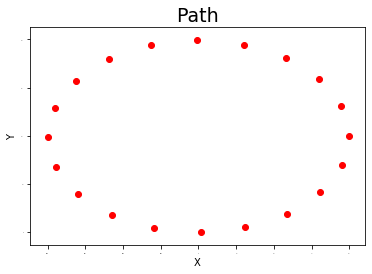

In [8]:
## --------
## TEST CASE #3:

length = 10.
bearing_noise  = 0.0
steering_noise = 0.0
distance_noise = 0.0

myrobot = Robot(length)
myrobot.set(0.0, 0.0, 0)
myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

number_of_iterations = 20
motions = [[0.1, 31.4] for row in range(number_of_iterations)]

for m in motions:
    myrobot.move(m)
    plt.scatter(myrobot.x, myrobot.y, c="red")
    print(myrobot.x, myrobot.y)
    print(myrobot.sense())
    
plt.title("Path", fontsize=19)
plt.xlabel("X", fontsize=10)
plt.ylabel("Y", fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=1)
plt.show()

## Задание 3

Реализуйте модель измерения мобильного робота $p(z_t|x_t, M)$. Метод должен иметь название *measurement_prob()*. Метод *measurement_prob()* принимает на вход вектор измерений $z$ и возвращает правдоподобие измерения. Правдоподобие рассчитывается как произведение четырех (по количеству ориентиров) нормальных распределений ошибок измерения. Каждое нормальное распределение показывает вероятность пеленга т.е. нормальное распределение ошибки для каждого пеленга имеет математиеское ожидание в истинном (ожидаемом) значении пеленга и дисперсию, задающуюся параметром *Robot.bearing_noise*.

**Важно:** не забывайте нормировать углы при рассчтете ошибок пеленга. Ошибка должна лежать в диапазоне $-\pi ... +\pi$.

**Важно:** для получения истинных (ожидаемых) значений измерений вы можете воспользоваться методом *sense()* с флагом *no_noise = True*.

Скопруйте класс Robot в ячейку ниже и добавьте к нему метод *measurement_prob()*.

## Задание 4

Запустите фильтр частиц на основе реализованного вами класс *Robot*. Добавьте пошаговую визуализацию работы фильтра чатсиц для второго тестового сценария. Визуализация должна отражать:
1. Карту с отмеченными положениями ориентиров.
2. Частицы - достаточно отразить только $(x, y)$.
3. Финальную оценку полоежния для каждого момента времени.

In [9]:
from math import *
import random

max_steering_angle = pi / 4.0 # You do not need to use this value, but keep in mind the limitations of a real car.
bearing_noise = 0.1 
steering_noise = 0.1
distance_noise = 5.0

tolerance_xy = 15.0 # Tolerance for localization in the x and y directions.
tolerance_orientation = 0.25 # Tolerance for orientation.


# --------
# 
# the "world" has 4 landmarks.
# the robot's initial coordinates are somewhere in the square
# represented by the landmarks.

In [10]:
# Some utility functions

def get_position(particles):
    particles_num = len(particles)
    x = 0.0
    y = 0.0
    orientation = 0.0
    for i in range(len(particles)):
        x += particles[i].x
        y += particles[i].y
        # orientation is tricky because it is cyclic. By normalizing
        # around the first particle we are somewhat more robust to
        # the 0=2pi problem
        orientation += (((particles[i].orientation - particles[0].orientation + pi) % (2.0 * pi)) 
                        + particles[0].orientation - pi)
    return [x / particles_num, y / particles_num, orientation / particles_num]


# The following code generates ground truth poses and measurements
def generate_ground_truth(motions):

    myrobot = Robot()
    myrobot.set_noise(bearing_noise, steering_noise, distance_noise)

    Z = []
    T = len(motions)

    for t in range(T):
        myrobot = myrobot.move(motions[t])
        Z.append(myrobot.sense())
        plt.scatter(myrobot.x, myrobot.y, c="green")
        
    plt.title("ground_truth", fontsize=19)
    plt.xlabel("X", fontsize=10)
    plt.ylabel("Y", fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=1)
    plt.show()
    
    #print 'Robot:    ', myrobot
    return [myrobot, Z]


# The following code prints the measurements associated
# with generate_ground_truth
def print_measurements(Z):

    T = len(Z)

    print ('measurements = ' + str(Z[0]))
    for t in range(1,T-1):
        print ('               ' + str(Z[t]))
    print (str(Z[T-1]))


# The following code checks to see if your particle filter
# localizes the robot to within the desired tolerances
# of the true position. The tolerances are defined at the top.
def check_output(final_robot, estimated_position):

    error_x = abs(final_robot.x - estimated_position[0])
    error_y = abs(final_robot.y - estimated_position[1])
    error_orientation = abs(final_robot.orientation - estimated_position[2])
    error_orientation = (error_orientation + pi) % (2.0 * pi) - pi
    correct = error_x < tolerance_xy and error_y < tolerance_xy \
              and error_orientation < tolerance_orientation
    return correct

In [11]:
def particle_filter(motions, measurements, N=500): # We will use 500 particles
    # --------
    #
    # Make particles
    # 

    particles = []
    for i in range(N):
        r = Robot()
        r.set_noise(bearing_noise, steering_noise, distance_noise)
        particles.append(r)

    # --------
    #
    # Update particles
    #     

    for t in range(len(motions)):
    
        # motion update (prediction)
        particles_after_motion = []
        for i in range(N):
            particles_after_motion.append(particles[i].move(motions[t]))
        particles = particles_after_motion

        # measurement update (correction)
        weights = []
        for i in range(N):
            weights.append(particles[i].measurement_prob(measurements[t]))

        # resampling
        particles_resampled = []
        index = int(random.random() * N)
        beta = 0.0
        mw = max(weights)
        for i in range(N):
            beta += random.random() * 2.0 * mw
            while beta > weights[index]:
                beta -= weights[index]
                index = (index + 1) % N
            particles_resampled.append(particles[index])
        particles = particles_resampled
        
        pos = get_position(particles)
        if (t % 2 == 0):
            color = "red" 
        else: 
            color = "green"
        plt.scatter(pos[0], pos[1], c=color)
        
    plt.title("particle filter", fontsize=19)
    plt.xlabel("X", fontsize=10)
    plt.ylabel("Y", fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=1)
    plt.show()
    
    return get_position(particles)

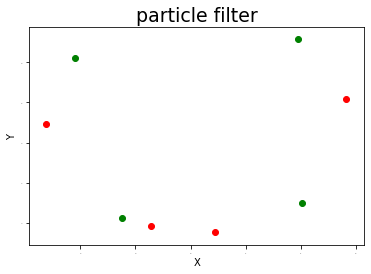

[98.80723016813134, 10.643185723964073, 5.7602163297901745]


In [12]:
## --------
## TEST CASE #1:
## 
##1) Calling the particle_filter function with the following
##    motions and measurements should return a [x,y,orientation]
##    vector near [x=93.476 y=75.186 orient=5.2664], that is, the
##    robot's true location.
##
motions = [[2. * pi / 10, 20.] for row in range(8)]
measurements = [[4.746936, 3.859782, 3.045217, 2.045506],
                [3.510067, 2.916300, 2.146394, 1.598332],
                [2.972469, 2.407489, 1.588474, 1.611094],
                [1.906178, 1.193329, 0.619356, 0.807930],
                [1.352825, 0.662233, 0.144927, 0.799090],
                [0.856150, 0.214590, 5.651497, 1.062401],
                [0.194460, 5.660382, 4.761072, 2.471682],
                [5.717342, 4.736780, 3.909599, 2.342536]]

print (particle_filter(motions, measurements))

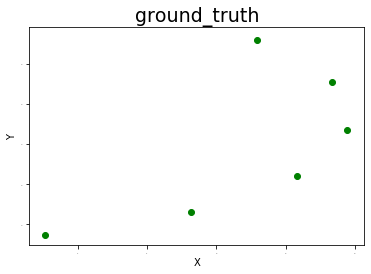

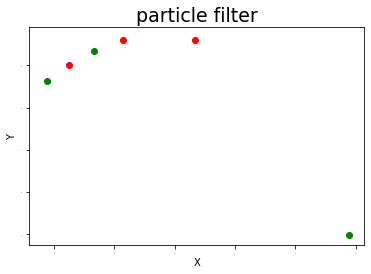

measurements = [4.008107989852466, 3.010758038240553, 2.195881898606487, 1.3717305390555214]
               [3.362175507000824, 2.6525606073354826, 1.8828882444516495, 1.1214147952348572]
               [2.9648578552169447, 2.320716840647478, 1.5759276446733779, 0.86320279308761]
               [2.6575254191299322, 2.0051232589314125, 1.2690639306537017, 0.5895991541613652]
               [2.3882357800802563, 1.6981679636776539, 0.9563762664430691, 0.2865302130134939]
[2.137438259690775, 1.393639546261726, 0.6310257819029772, 6.206409271351992]
Ground truth:     [x=122.91 y=65.999 theta=2.2407]
Particle filter:  [78.89975908691831, 86.24438955183719, 4.06512245020707]
Code check:       False


In [13]:
## --------
## TEST CASE #2:
##
## 2) You can generate your own test cases by generating
##    measurements using the generate_ground_truth function.
##    It will print the robot's last location when calling it.
##

number_of_iterations = 6
motions = [[2. * pi / 20, 12.] for row in range(number_of_iterations)]

x = generate_ground_truth(motions)
final_robot = x[0]
measurements = x[1]
estimated_position = particle_filter(motions, measurements)
print_measurements(measurements)
print('Ground truth:    ', final_robot) 
print('Particle filter: ', estimated_position)
print('Code check:      ', check_output(final_robot, estimated_position)) 

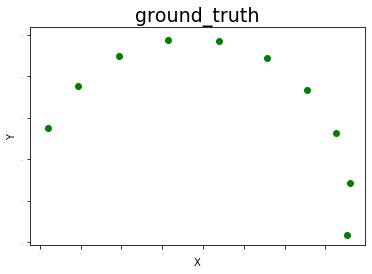

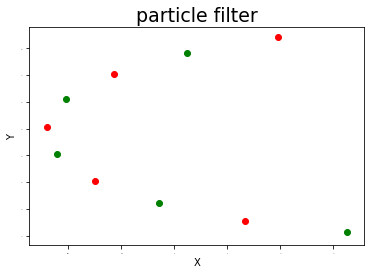

measurements = [3.494356468052688, 2.6533260743892644, 1.8008822277079801, 4.802452989195405]
               [3.1528708616105767, 2.3854875987200455, 1.6238992051720604, 3.8093339975265224]
               [2.84673080679611, 2.1305861405338735, 1.4471709116432718, 3.2948083383025217]
               [2.5656349239870373, 1.8837128721528487, 1.269841572970888, 2.9761254323617496]
               [2.3015724611732065, 1.6410354773926805, 1.0909241306509028, 2.726899982580429]
               [2.04862773030127, 1.3992720395853757, 0.9090491969979082, 2.508054699434412]
               [1.8023380090510308, 1.1552588551903682, 0.7219967978865149, 2.3046786517429787]
               [1.5591049242258297, 0.9055400763358641, 0.5256147183781064, 2.1099179479054584]
               [1.3157200732635266, 0.6459043906214799, 0.3107931281849492, 1.9201195518104548]
[1.0689558338673217, 0.3708031755267971, 0.05268562002441257, 1.7330550265947444]
Ground truth:     [x=11.996 y=127.45 theta=4.2477]
Particle fil

In [14]:
## TEST CASE #3:

bearing_noise  = 0.001
steering_noise = 0.001
distance_noise = 0.01

number_of_iterations = 10
motions = [[0.25, 12.56] for row in range(number_of_iterations)]

x = generate_ground_truth(motions)
final_robot = x[0]
measurements = x[1]
estimated_position = particle_filter(motions, measurements, 1000)
print_measurements(measurements)
print('Ground truth:    ', final_robot) 
print('Particle filter: ', estimated_position)
print('Code check:      ', check_output(final_robot, estimated_position)) 